The purpose of this notebook is to implement some of the ideas and contents of Beyerer, Puente Leon, ... Machine Vision

# 9 Preprocessing and Image Enhancement

## 9.1 Simple image enhancement methods

### 9.1.1 contrast adjustment by histogram stretching

Contrast stretching ist just a linear transformation so that the new image values completely fill the range of the given datatyp ( 0...255 in 8bit case).

Sometimes, it performes better to use the 2% and 98% borders of the histogram of the original image as the new image's range ( [p2, p98] --> [0, 256] ).

Taking a look at the cumulative distribution function, a contrast stretch aims at a wide "S" shape of the curve.

In [2]:
%matplotlib inline

from skimage import data, io, filters, color
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

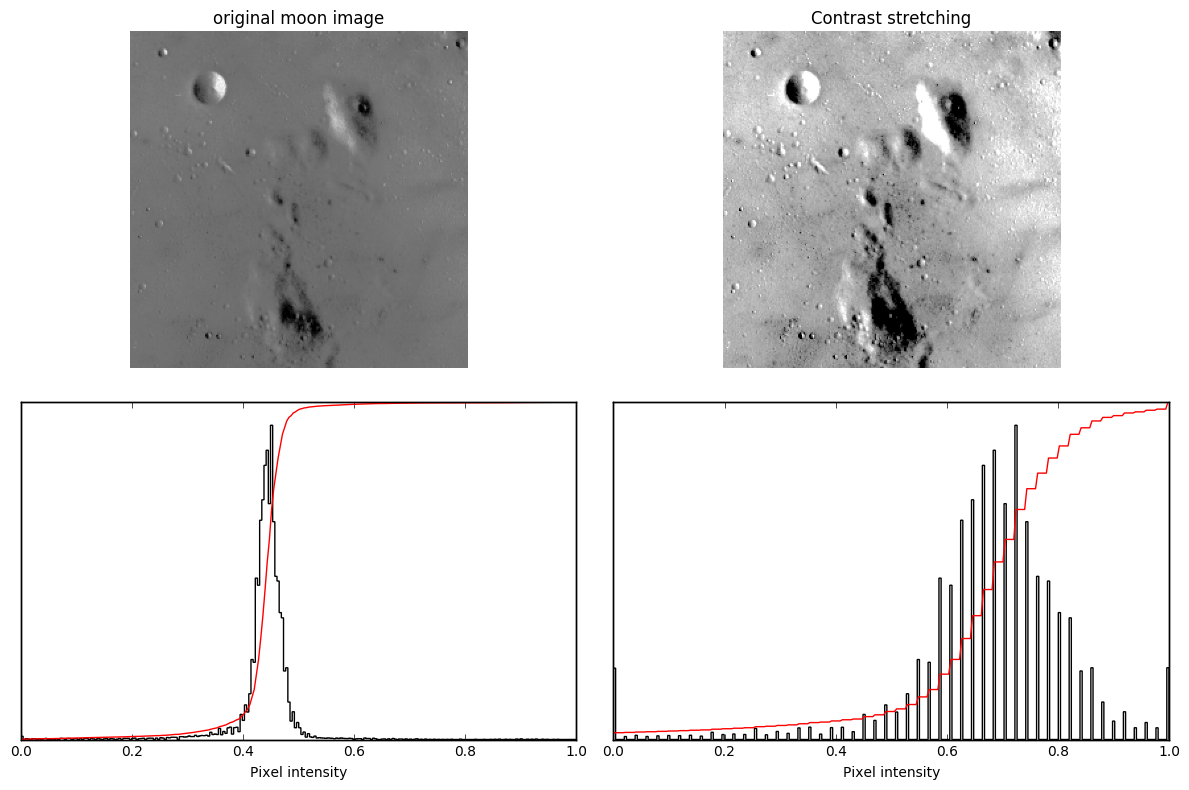

In [24]:
from skimage import exposure
from skimage import img_as_float


def plot_img_and_hist( img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""

    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()  # cumulative distributive function
    
    #Display image
    
    ax_img.imshow(img, cmap = cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')
    
    #Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black') ## this is np.hist not skimage.exposure.histogram
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0,1)
    ax_hist.set_yticks([])
    
    #Display cumulative distribution
    
    img_cdf, bins = exposure.cumulative_distribution(img,bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])
    
    return ax_img, ax_hist, ax_cdf



im = data.moon()

## perform contrast stretching with complete range
pLow, pHigh = (2,98)  ## choose these values freely
lowC, highC = np.percentile(im, (pLow, pHigh))
img_streched = exposure.rescale_intensity(im, in_range=(lowC, highC))


## prepare the plot
fig, axes = plt.subplots(2,2, figsize=(12,8))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(im, axes[:,0])
ax_img.set_title("original moon image")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_streched, axes[:,1])
ax_img.set_title("Contrast stretching")

## final adjustemnts
fig.tight_layout()
plt.show()


### 9.1.2 Histogram manipulation

It might be desirable to achieve a special cumulative distribution function of the resulting image. Assuming that $g$ denotes the original image values, the cumulative distribution function of the original image is given by
\begin{align}
    F_g(g) = \int\limits_{-\infty}^{g} {f_g(\alpha)} ~\mathrm{d} \alpha.
\end{align}
After the transformation $\gamma : [g_{low}, g_{high}] \rightarrow [\gamma(g_{low}) ,\gamma(g_{high})]$, the cumulative distribution of the transformed image $\gamma{g}$ is given by 
\begin{align}
F_\gamma(\gamma(g)) = \int\limits_{-\infty}^{\gamma(g)} {f_\gamma(\beta) }\mathrm{d} \beta.
\end{align}



Because the original cumulative density function range of values [0,1] is a closed interval and the cumulative density function is strictly monotonous, the inversion of $F_\gamma$ is possible. This yields
\begin{align}
\gamma(g)=F_\gamma^{-1}(F_g(g))
\end{align}
as the desired transformation function.


#### special case: Equalization

It could be helpfull to aim at a certain distribution function, e.g. equal distribution of the grayscale values. In this case, the cumulative distribution function would be a linear function, which results in a staircase function due to the discretazation. This is called histogram equalization.
The $\gamma$-function in this case is:

\begin{align}
\gamma(g) = c^{-1} \cdot F_g(g) + \gamma_{min} \Longleftrightarrow f_\gamma(\gamma) = c(\sigma(\gamma - \gamma_{min}) - \sigma(\gamma - \gamma_{max}))
\end{align}

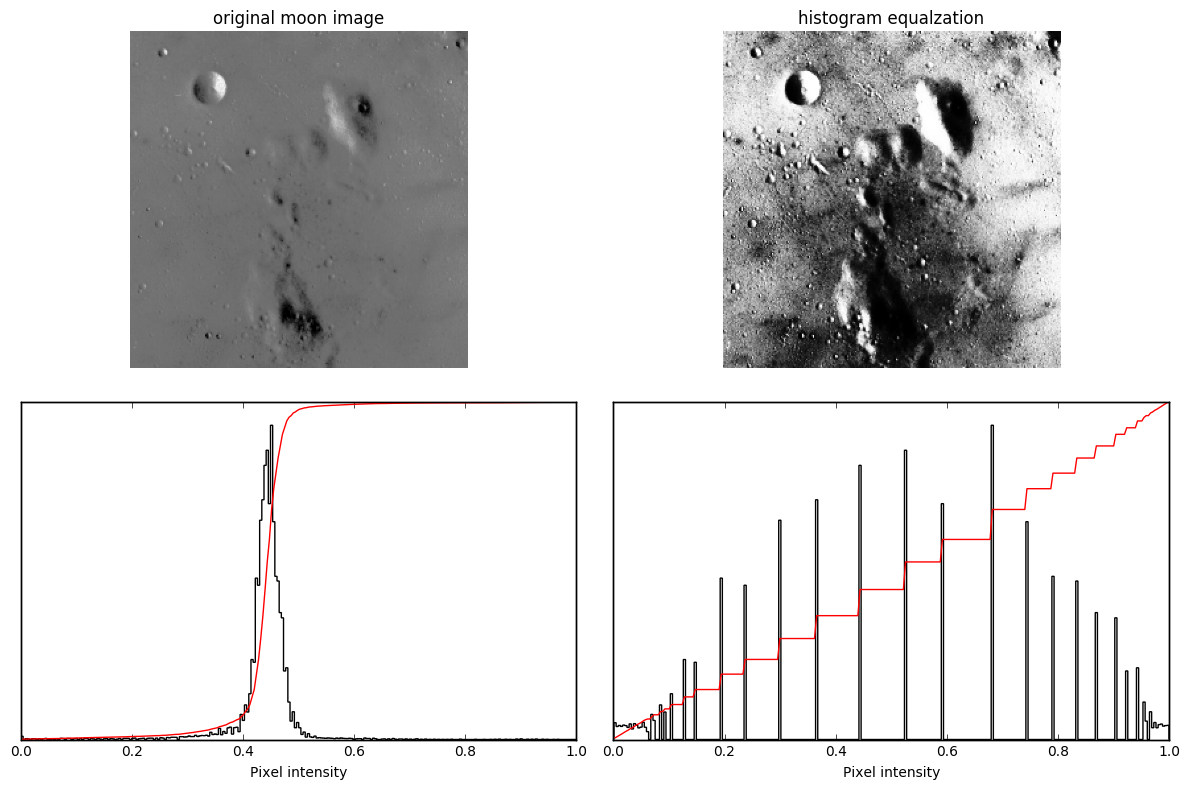

In [3]:
im = data.moon()
im_equalized = exposure.equalize_hist(im)


## prepare the plot
fig, axes = plt.subplots(2,2, figsize=(12,8))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(im, axes[:,0])
ax_img.set_title("original moon image")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(im_equalized, axes[:,1])
ax_img.set_title("histogram equalzation")

## final adjustemnts
fig.tight_layout()
plt.show()


### 9.1.3 Pseudo-color images and False color images

Transform a greyscale image into a color image for bettervisualization. Do not mistake this with *False-color images*.

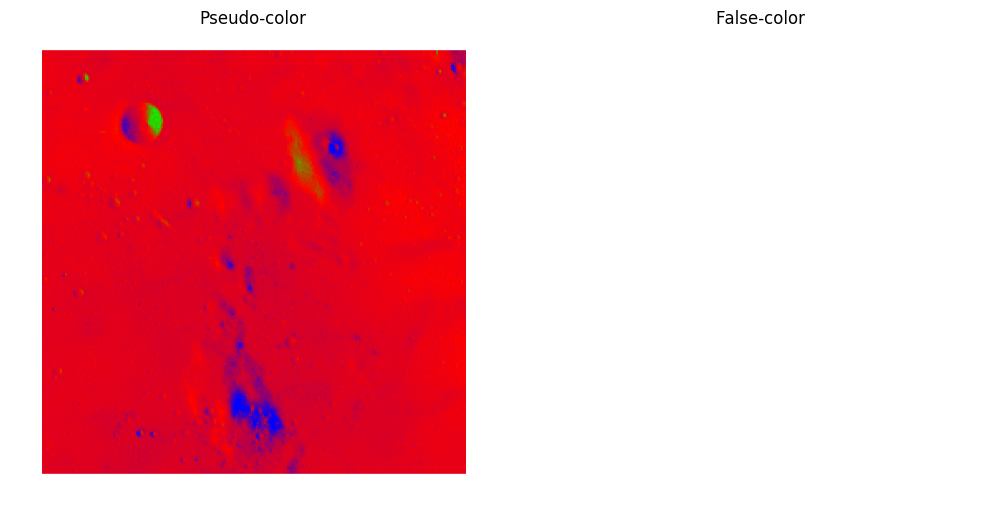

In [30]:
im = data.moon()
im = color.rgb2gray(im)

fig,axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]
ax.imshow(im, cmap=cm.brg)
ax.set_axis_off()
ax.set_title("Pseudo-color")

ax = axes[1]
ax.set_axis_off()
ax.set_title("False-color")

### Additional Content 1 - CLAHE for adaptive histogram equalization

An algorith for local contrast enhancement that uses histograms computed over different tile regions of the image.

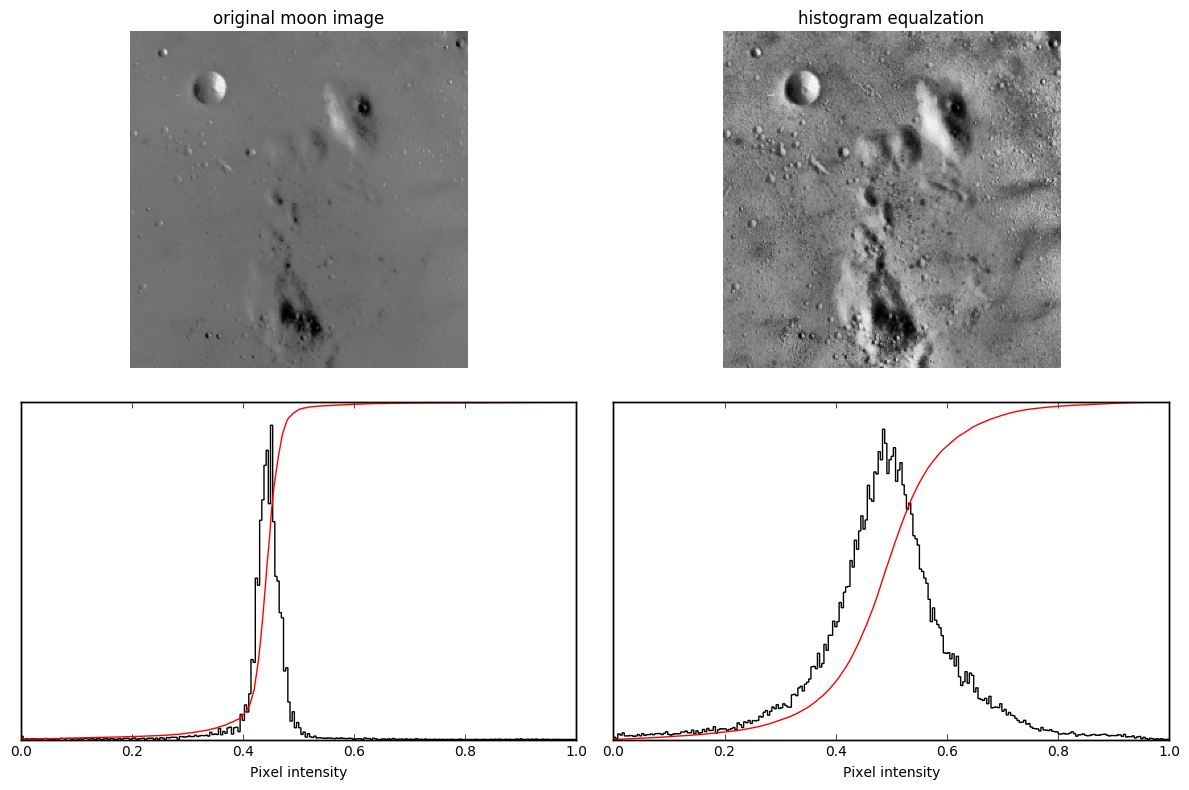

In [32]:
im = data.moon()
im_adapteq = exposure.equalize_adapthist(im, clip_limit = 0.03)

## prepare the plot
fig, axes = plt.subplots(2,2, figsize=(12,8))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(im, axes[:,0])
ax_img.set_title("original moon image")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(im_adapteq, axes[:,1])
ax_img.set_title("histogram equalzation")

## final adjustemnts
fig.tight_layout()
plt.show()

### 9.1.4 Image sharpening

Because of details correspond to high spatial frequencies, a highpass has to be applied. In order not to change the average gray level, $H(0)=1$ has to be true which corresponds to $\sum h_{mn} = 1$ in the spatial domain.

The impulse response of the sharpening filter is given by:
\begin{align}
    v(u,v) &= \frac{1}{1-\alpha} - \frac{\alpha}{1-\alpha} \cdot \mathrm{lp}(u,v) \\
\end{align}
with an $\alpha \in (0,1)$.

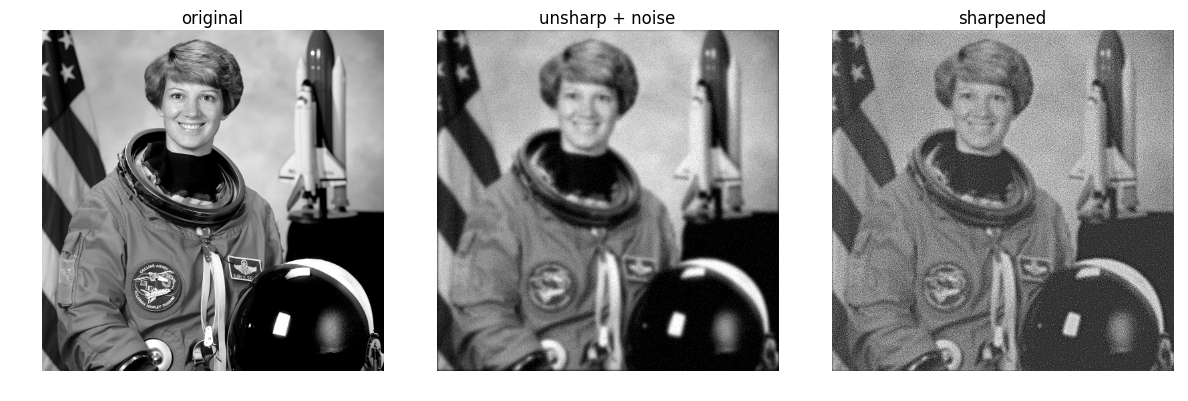

In [5]:
from skimage import filters, util
import scipy
from scipy import signal
from scipy import ndimage
import math

def binomialSeries(L):
    out = np.zeros(L)
    for m in range(0,L):
        out[m] = math.factorial(L-1)/(math.factorial(m) * math.factorial(L-m-1))
    return out

kernel = binomialSeries(11) 
kernel = kernel / np.sum(kernel) ## maintain average gray level
kernel = np.outer(kernel,kernel)

im = data.astronaut()
im = img_as_float(color.rgb2gray(im))
im_original = im

### make the image blurry and noisy
sigma = 0.001
mean=0
im = scipy.signal.convolve(im, kernel, mode='same')
im = scipy.signal.convolve(im, kernel, mode='same') # results in order 13 lowpass
im = util.random_noise(im, mode='gaussian', var=sigma, mean=mean)

alpha = 0.75
im_sharpened = im/(1-alpha) - alpha/(1-alpha) * scipy.signal.convolve(im, kernel, mode='same')
#im_sharpened[im_sharpened>1] = 1

## do the plotting
fig, axes = plt.subplots(1,3, figsize=(12,6))
ax = axes[0]
ax.imshow(im_original, cmap=cm.gray)
ax.set_title("original")

ax = axes[1]
ax.imshow(im, cmap=cm.gray)
ax.set_title("unsharp + noise")

ax = axes[2]
ax.imshow(im_sharpened, cmap=cm.gray)
ax.set_title("sharpened")

for ax in axes:
    ax.set_axis_off()
    
fig.tight_layout()
plt.show()

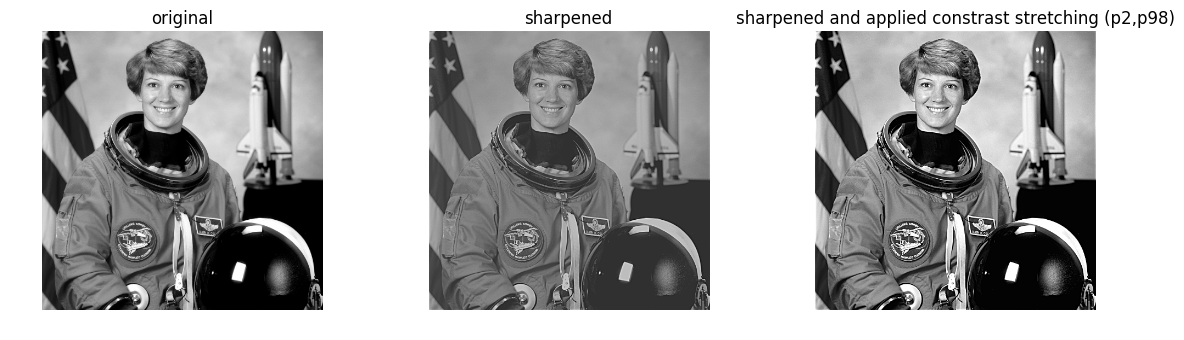

<function __main__.interaction>

In [11]:
from skimage import filters, util
import scipy
from scipy import signal
from scipy import ndimage
import math
from IPython.html.widgets import *



def binomialSeries(L):
    out = np.zeros(L)
    for m in range(0,L):
        out[m] = math.factorial(L-1)/(math.factorial(m) * math.factorial(L-m-1))
    return out


kernel = binomialSeries(11) 
kernel = kernel / np.sum(kernel) ## maintain average gray level
kernel = np.outer(kernel,kernel)

im = data.astronaut()
im = img_as_float(color.rgb2gray(im))
im_original = im


def interaction(alpha):
    im_sharpened = im/(1-alpha) - alpha/(1-alpha) * scipy.signal.convolve(im, kernel, mode='same')
    (lowC, highC) = np.percentile(im_sharpened,(2,98))
    im_sharpRescaled = exposure.rescale_intensity(im_sharpened, (lowC, highC))
    ## do the plotting
    fig, axes = plt.subplots(1,3, figsize=(12,6))
    ax = axes[0]
    ax.imshow(im_original, cmap=cm.gray)
    ax.set_title("original")

    ax = axes[1]
    ax.imshow(im_sharpened, cmap=cm.gray)
    ax.set_title("sharpened")

    ax = axes[2]
    ax.imshow(im_sharpRescaled, cmap=cm.gray)
    ax.set_title("sharpened and applied constrast stretching (p2,p98)")
    
    for ax in axes:
        ax.set_axis_off()

    fig.tight_layout()
    plt.show()


interact(interaction, alpha=(0.01,0.98,0.05))

## 9.2.2.2 Homogeneity

#### Division by a reference image

If the signal Model can be assumed to be multiplicative, a division by a reference image will do the trick.

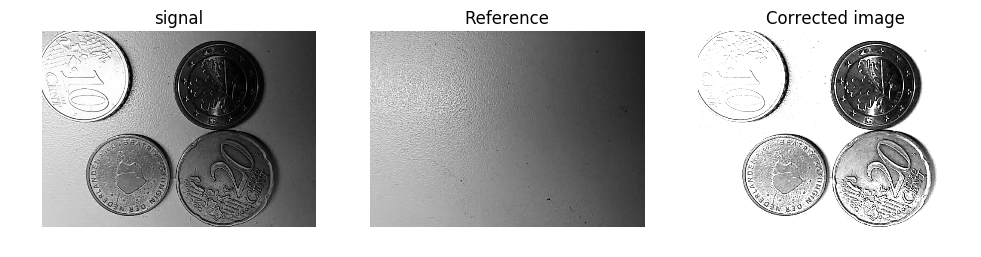

In [172]:
signal = io.imread("coins.jpeg")
signal = img_as_float(color.rgb2gray(signal))
signal = signal[0:-20,:]

ref = io.imread("background.jpeg")
ref = img_as_float(color.rgb2gray(ref))
ref = ref[0:-20,:]

corrected = signal/ref
corrected[corrected>1] = 1

fig,axes = plt.subplots(1,3,figsize=(12,6))

ax = axes[0]
ax.imshow(signal, cmap=cm.gray)
ax.set_title("signal")

ax = axes[1]
ax.imshow(ref, cmap=cm.gray)
ax.set_title("Reference")

ax = axes[2]
ax.imshow(corrected, cmap=cm.gray)
ax.set_title("Corrected image")

for ax in axes:
    ax.set_axis_off()

What happens if we equalize the histogram of the corrected image?

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


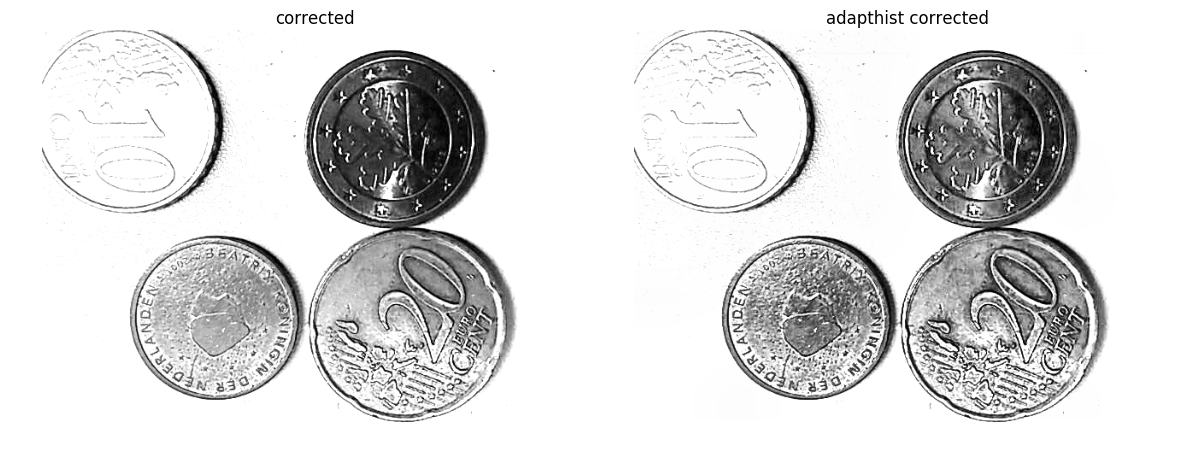

In [180]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.imshow(corrected, cmap=cm.gray)
ax.set_axis_off()
ax.set_title("corrected")

ax = axes[1]
ax.imshow(exposure.equalize_adapthist(corrected), cmap=cm.gray)
ax.set_axis_off()
ax.set_title("adapthist corrected")

fig.tight_layout()
plt.show()

### 9.2.2.3 Homomorphic filtering

Also in this case a multiplicative model is assumed with $s(x)$ being the desired real-world signal and $b(x)$ being the inhomogenity (due to illumination).
\begin{align}
    g(x) = s(x) \cdot b(x)
\end{align}.

If it can be assumed that $b(x)$ is very slow (low frequency support) compared to the signal $s(x)$. To get rid of the multiplikative signal model, a logarithmic transformation is used.

\begin{align}
    ln(g(x)) = ln(b(x)) + ln(s(x))
\end{align}

An appropriately designed highpass filter can now seperate the supports of both signals. A suitable filter would be
\begin{align}
H(\boldsymbol(f)) = 
\begin{cases}
    1 & if \boldsymbol{f = 0} \\
    \alpha - (\alpha - \beta)exp \left( - \frac{ \lVert \boldsymbol{f} \rVert}{\rho^2} \right) & otherwise
\end{cases}
\end{align}

/home/sandro/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/sandro/.local/lib/python3.5/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


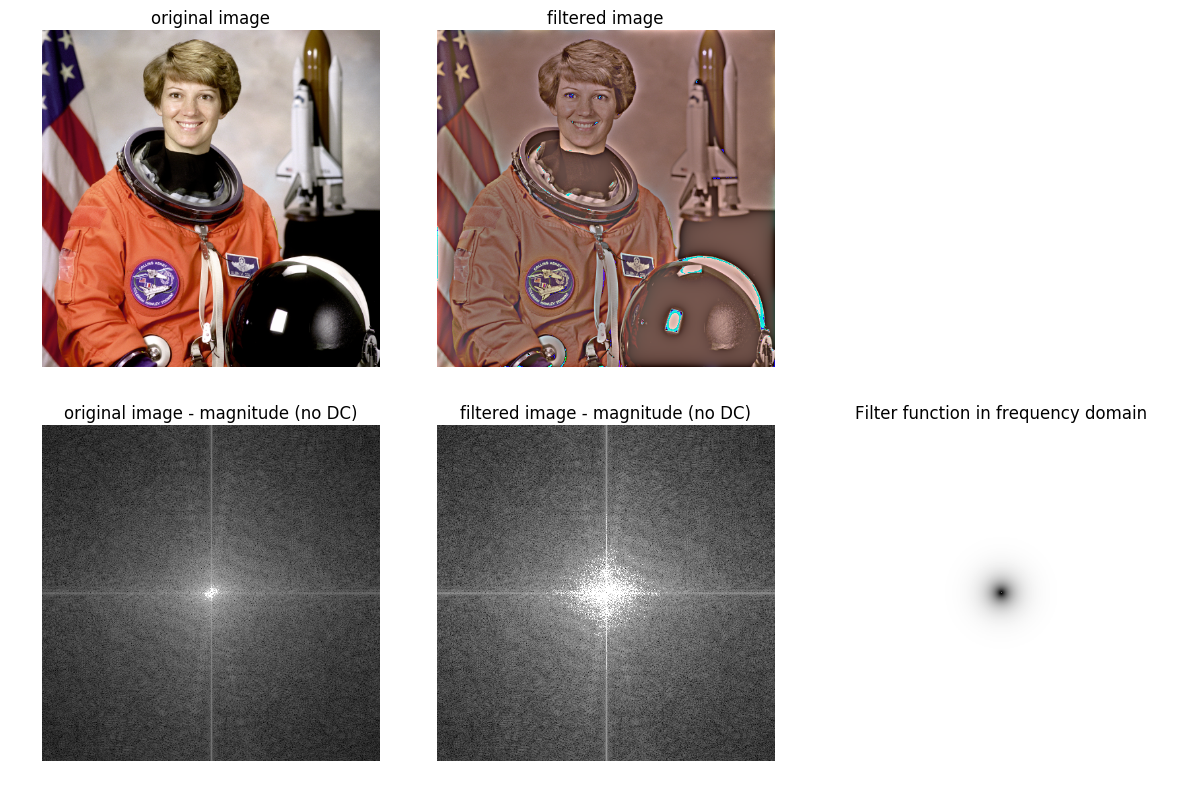

In [284]:
def highpass(a,b,R, size):
    (Nu, Nv) = size
    #u,v = np.meshgrid(np.linspace(0,0.5,Nu), np.linspace(0,0.5, Nv))
    u,v, = np.meshgrid(np.arange(-Nu,Nu), np.arange(-Nv,Nv))
    H = a - (a-b)*np.exp(-(np.sqrt(u**2+v**2)/ R**2))
    H[Nu,Nv] = 1
    return H

a = 1
b = 0
R = 4
H = highpass(a,b,R, (im.shape[0]/2 ,im.shape[1]/2))
H = np.fft.ifftshift(H)

im = data.astronaut()
im = img_as_float(im)
filtered = np.zeros_like(im)
for k in range(3):
    channel = im[:,:,k]    
    channel = np.log(1+channel)
    filtered[:,:,k] = np.fft.ifft2(np.fft.fft2(channel) * H)
    filtered[:,:,k] = np.exp(filtered[:,:,k])-1

    
def plot_img_and_mag(im, axes):
    """a function to plot an image and its magnitude spectrum to given axes objects"""
    ax_im, ax_mag = axes
    
    ## display image
    ax_im.imshow(im, cmap=cm.brg)

    ## display magnitude        
    mag = np.abs(np.fft.fft2(color.rgb2gray(im)))
    mag[0,0] = 0
    mag[mag>(np.max(mag)*0.1)] = np.max(mag)
    mag = np.log(1+mag)
    mag = np.fft.fftshift(mag)
    ax_mag.imshow(mag, cmap=cm.gray)
    
    return ax_im, ax_mag

fig,axes = plt.subplots(2,3, figsize=(12,8))


## originial image
ax_im, ax_mag = plot_img_and_mag(im, axes[:,0])
ax_im.set_title("original image")
ax_mag.set_title("original image - magnitude (no DC)")


## filtered image
ax_im, ax_mag = plot_img_and_mag(filtered, axes[:,1])
ax_im.set_title("filtered image")
ax_mag.set_title("filtered image - magnitude (no DC)")


ax = axes[1,2]
#ax.imshow(np.fft.ifftshift(H), cmap=cm.brg)
ax.imshow(np.log(1+np.fft.ifftshift(H)), cmap=cm.gray)
ax.set_title("Filter function in frequency domain")

for ax in axes.ravel():
    ax.set_axis_off()

fig.tight_layout()
plt.show()

### Homogenization of first degree

A homogenization of first degree requires the signal model to be additive
\begin{align}
    g(x) = b(x) + s(x).
\end{align}

The homogenization of first degree can be realized using a high-pass filter:
\begin{align}
\hat{s}(x) = g(x) - \mathrm{lp} \left\{ g(x) \right\}
\end{align}

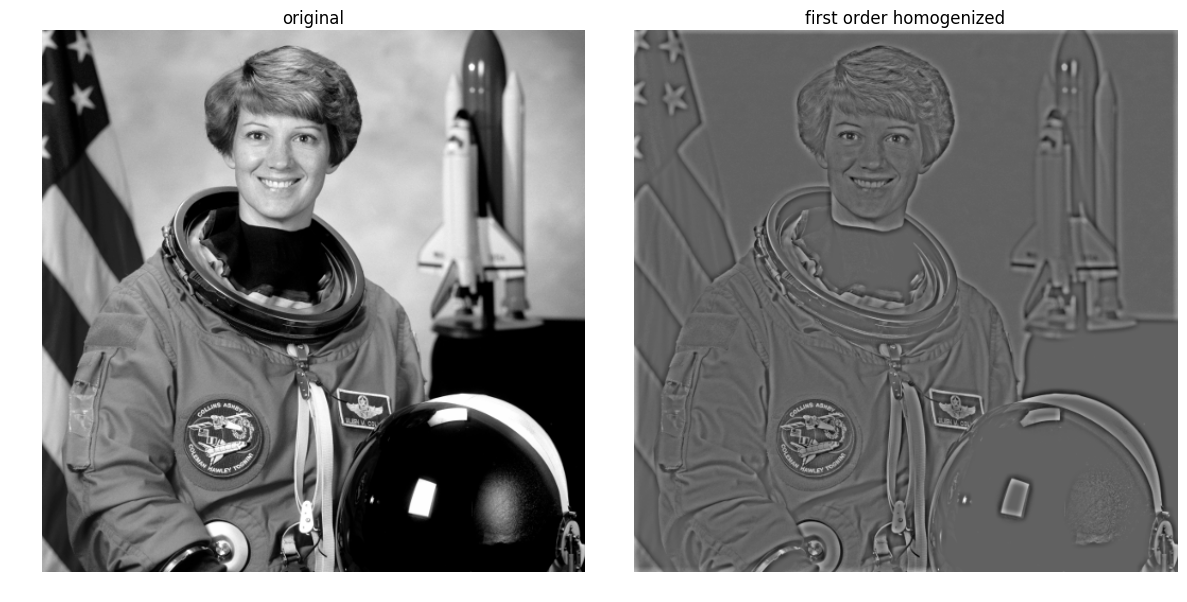

In [10]:
import math
from skimage import img_as_float, exposure, data
import scipy

kernel = np.ones(11) ## averaging fir
kernel = kernel / np.sum(kernel) ##
kernel = np.outer(kernel,kernel)

im = data.astronaut()
im = img_as_float(color.rgb2gray(im))
im_original = im


im_sharpened = im - scipy.signal.convolve(im, kernel, mode='same')

## do the plotting
fig, axes = plt.subplots(1,2, figsize=(12,6))
ax = axes[0]
ax.imshow(im_original, cmap=cm.gray)
ax.set_title("original")

ax = axes[1]
ax.imshow(im_sharpened, cmap=cm.gray)
ax.set_title("first order homogenized")

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()
plt.show()

### Second order homogenization

The second order homogenization equalizes the local mean image value and the local contrast. The signal model is assumed as follows:
\begin{align}
g(x) = \sigma(x) \cdot s(x) + \mu (x).
\end{align}
Obviously the inhomogenity $b(x)$ has been seperated into two apatially slowly varying components $\sigma(x)$ and $\mu(x)$. As always, $b(x)$ is assumed to have a low frequency support. $s(x)$ is assumed to have high frequency support.

Opposed to the prior case, $s(x)$ is assumed to be zero-mean and constant contrast within a sufficiently large region $\mathrm{U}$.

The procedure is as follows:
\begin{align}
\hat{\mu}(x) = \mathrm{LP}(g(x))
\end{align}
This is the result of the first oder homogenization.

\begin{align}
\hat{\sigma}(x) &= \sqrt{\mathrm{LP} \left\{ (g(x) - \hat{\mu}(x))^2 \right\} } \\
\hat{s}_{\mathrm{hom,2}}(x) &= \frac{g(x) - \hat{\mu}(x)}{\hat{\sigma}(x)} \cdot \mathrm{const}
\end{align}
The division by $\hat{\sigma}(x)$ correspondes to the second order homgenization. 

After the homogenization procedure, a constant average gray-level and constant contrast can be set freely.

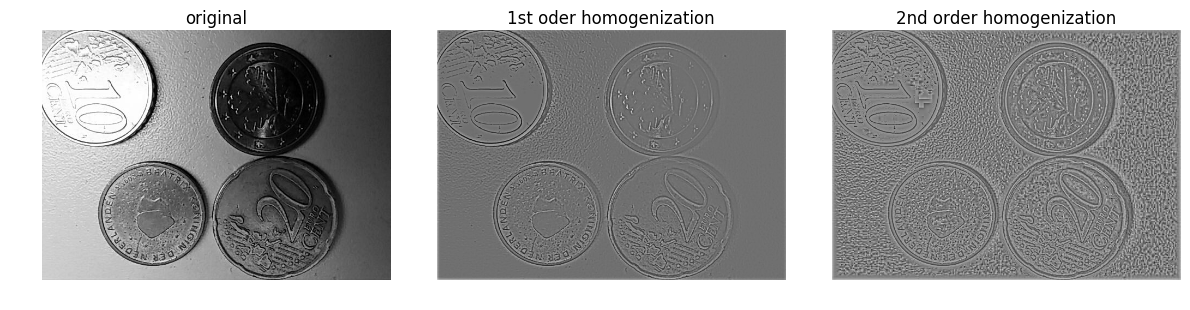

In [34]:
def homogenize1order(im, lpKernel):    
    homogenized = im - scipy.signal.fftconvolve(im, lpKernel, mode='same')
    return homogenized


def homogenize2order(im, lpKernel):
    homo1 = homogenize1order(im,lpKernel)
    sigma = np.sqrt(scipy.signal.fftconvolve(homo1**2, lpKernel, mode='same'))
    
    return homo1/sigma

im = color.rgb2gray(img_as_float(io.imread("coins.jpeg")))
im = im[0:-20,:]
kernel = binomialSeries(25)
kernel = np.outer(kernel, kernel) / (np.sum(kernel)**2)

homo1 = homogenize1order(im, kernel)
homo2 = homogenize2order(im, kernel)

fig, axes = plt.subplots(1,3, figsize=(12,6))

names = ["original", "1st oder homogenization", "2nd order homogenization"]
pics = [im, homo1, homo2]

for k in range(len(axes)):
    ax = axes[k]
    ax.imshow(pics[k], cmap=cm.gray)
    ax.set_axis_off()
    ax.set_title(names[k])
    
fig.tight_layout()
plt.show()

Why not add a histogram equalization to the homogenized images?

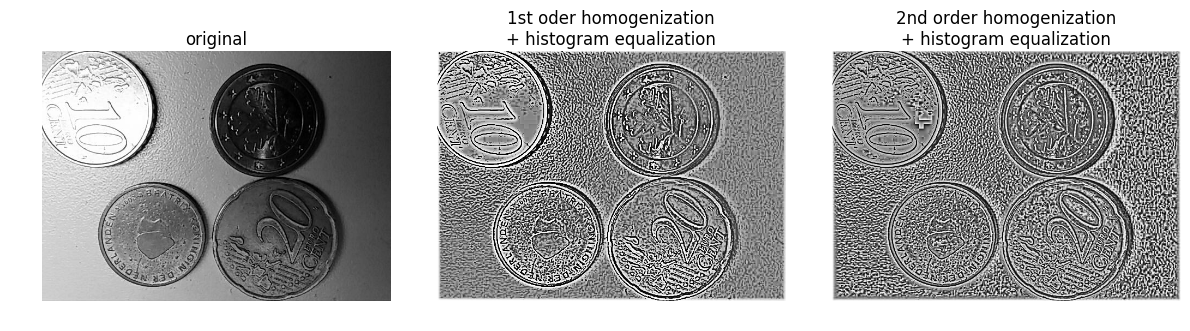

In [36]:
def homogenize1order(im, lpKernel):    
    homogenized = im - scipy.signal.fftconvolve(im, lpKernel, mode='same')
    return homogenized


def homogenize2order(im, lpKernel):
    homo1 = homogenize1order(im,lpKernel)
    sigma = np.sqrt(scipy.signal.fftconvolve(homo1**2, lpKernel, mode='same'))
    
    return homo1/sigma

im = color.rgb2gray(img_as_float(io.imread("coins.jpeg")))
im = im[0:-20,:]
kernel = binomialSeries(25)
kernel = np.outer(kernel, kernel) / (np.sum(kernel)**2)

homo1 = homogenize1order(im, kernel)
homo1 = exposure.equalize_hist(homo1)
homo2 = homogenize2order(im, kernel)
(lowC, highC) = np.percentile(homo2, (2,98))
#homo2 = exposure.rescale_intensity(homo2, (lowC, highC))
homo2 = exposure.equalize_hist(homo2)

fig, axes = plt.subplots(1,3, figsize=(12,6))

names = ["original", "1st oder homogenization\n+ histogram equalization", "2nd order homogenization\n+ histogram equalization"]
pics = [im, homo1, homo2]

for k in range(len(axes)):
    ax = axes[k]
    ax.imshow(pics[k], cmap=cm.gray)
    ax.set_axis_off()
    ax.set_title(names[k])
    
fig.tight_layout()
plt.show()

It is hard to notice, but the first oder homogenization does have local contrast variations due to inhomogenious lighting. Those variations have been eliminated in the second order homogenization.

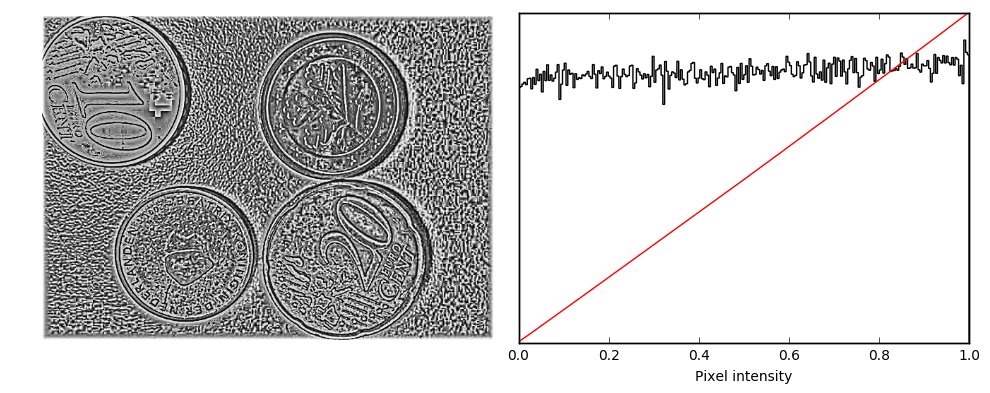

In [40]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

ax_im, ax_hist, ax_cdf = plot_img_and_hist(homo2, axes)

fig.tight_layout()
plt.show()

## 9.3.1 Linear Filters

all that MA, binomial, etc... stuff

## Nonlinear Filters

### 9.3.2.1 Median Filter

The Median Filter is a special case of the rank filter

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


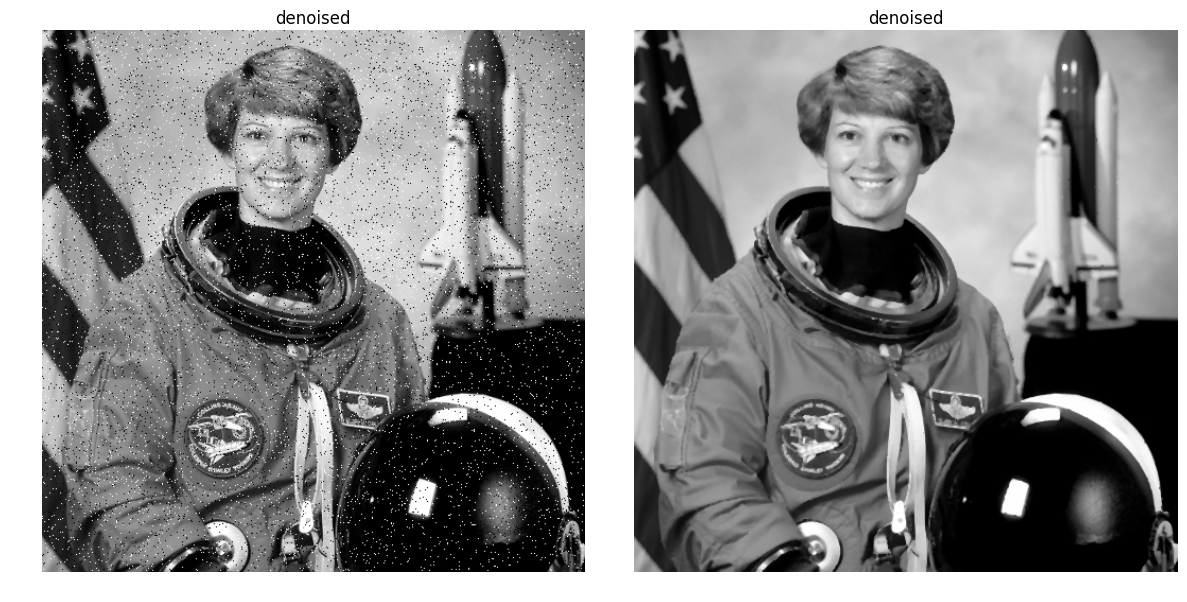

In [54]:
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage import util

im = img_as_float(color.rgb2gray(data.astronaut()))
#im_noisy = util.random_noise(im, var=0.01, mean=0)
im_noisy = util.random_noise(im, mode='s&p')

im_denoised = median(im_noisy, np.ones((3,3))) 
#im_denoised = median(im_noisy, disk(2)) 


fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.imshow(im_noisy, cmap=cm.gray)
ax.set_title("denoised")
ax.set_axis_off()

ax = axes[1]
ax.imshow(im_denoised, cmap = cm.gray)
ax.set_title("denoised")
ax.set_axis_off()

fig.tight_layout()
plt.show()

#### Trimmed Mean Filter

### 9.3.2.3 Bilateral Filter

The biltaeral is a very powerful appreoach to edge-preserving smoothing. The ideas is to only smooth image values that have similar image values

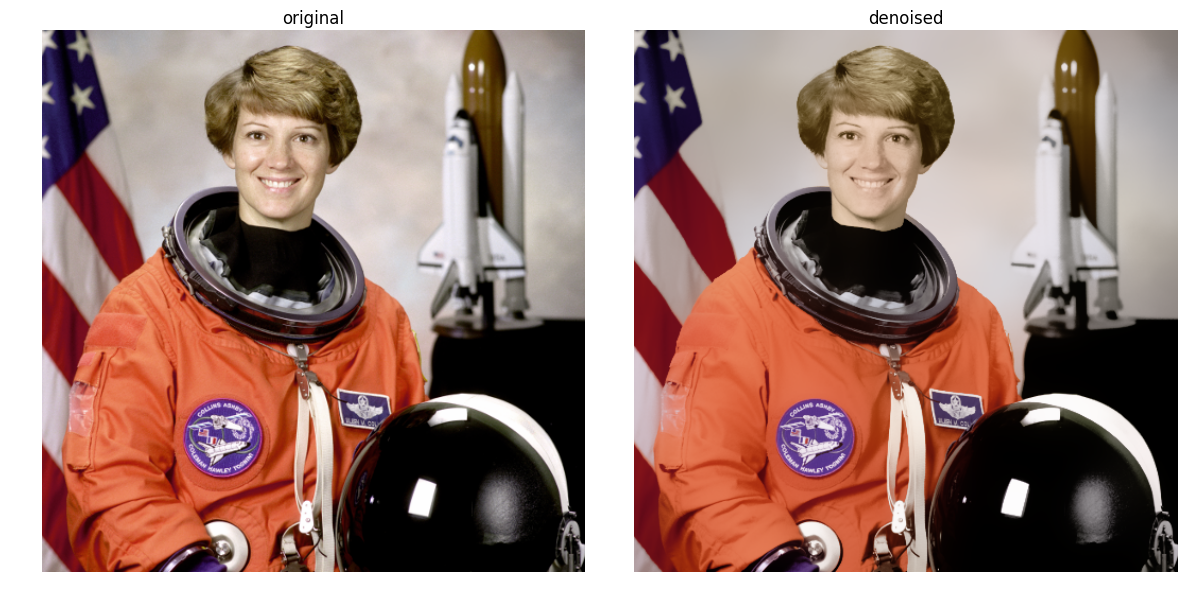

In [88]:
from skimage.filters.rank import *
from skimage.restoration import denoise_bilateral
from skimage.morphology import disk
from skimage import util

im = img_as_float((data.astronaut()))

im_denoised = denoise_bilateral(im, sigma_color=0.05, sigma_spatial=15)

fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.imshow(im, cmap=cm.brg)
ax.set_title("original")
ax.set_axis_off()

ax = axes[1]
ax.imshow(im_denoised, cmap = cm.brg)
ax.set_title("denoised")
ax.set_axis_off()

fig.tight_layout()
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


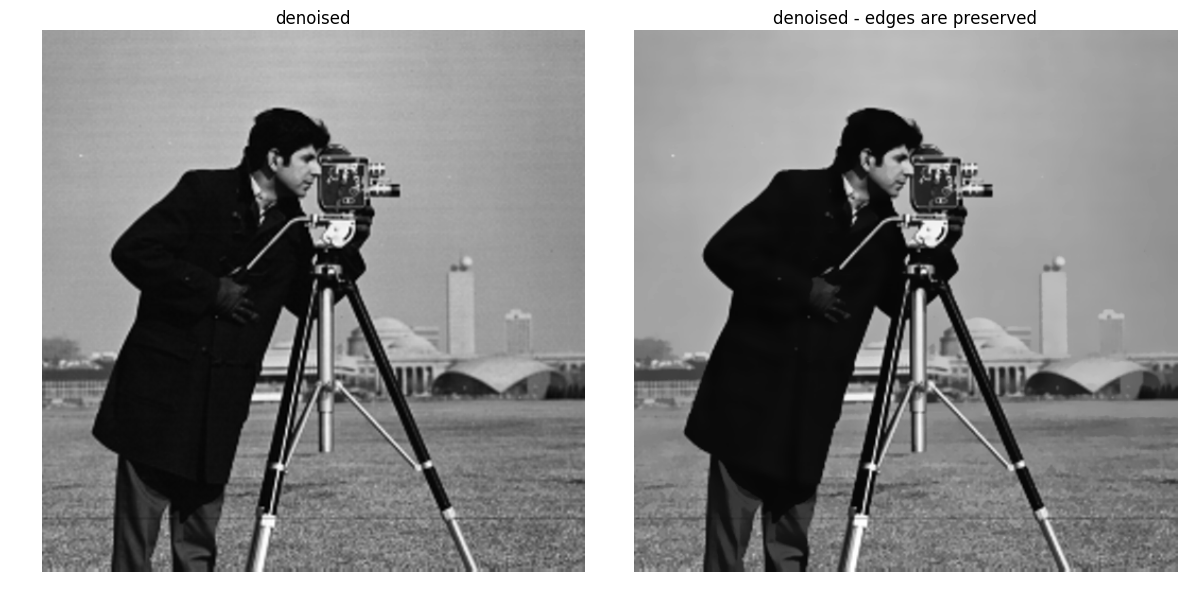

In [78]:
from skimage.filters.rank import *
from skimage.morphology import disk
from skimage import util

im = img_as_float(color.rgb2gray(data.camera()))

im_denoised = mean_bilateral(im, selem=np.ones((11,11)))

fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.imshow(im, cmap=cm.gray)
ax.set_title("denoised")
ax.set_axis_off()

ax = axes[1]
ax.imshow(im_denoised, cmap = cm.gray)
ax.set_title("denoised - edges are preserved")
ax.set_axis_off()

fig.tight_layout()
plt.show()

## 9.4 Image Registration

In [95]:
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift


im = data.camera()
shift = (3.33333, 2.125)
im_offset = fourier_shift(np.fft.fftn(im), shift)
im_offset = np.fft.ifftn(im_offset)

print("Known offset (y,x): ")
print(shift)

## pixel offset
shift, error, diffphase = register_translation(im, im_offset)
print("Detected pixel offset (y,x): ")
print(shift)

## subpixel offset
shift, error, diffphase = register_translation(im, im_offset, 100)
print("Detected subpixel offset (y,x): ")
print(shift)


Known offset (y,x): 
(3.33333, 2.125)
Detected pixel offset (y,x): 
[-3. -2.]
Detected subpixel offset (y,x): 
[-3.33 -2.13]
